# Machine learning

#### Predicting successful preventions

I started with a simple linear regression model to predict the number of successful preventions achieved, given the number of prevention duties owed. There is a strong correlation between these two variables.

I then created a multiple linear regression model to predict the number of successful preventions achieved, given various other factors. The region field needed to be one hot encoded so it could be used in the model. I identified the most influential features for the prediction.

I ran another model to include the Homelessness Prevention Grant data, which excludes a lot of the full dataset as I only had this information for two years of data. My hypothesis was that successful preventions would increase as grant funding increased, however my results did not confirm this.

#### Predicting number of prevention duties

I then worked on predicting the number of prevention duties owed (i.e. the number of households threatened with homelessness), based on area characteristics of deprivation, unemployment, median age, region, population density and housing affordability ratio. This was more challenging.

- My linear regression model achieved poor results on both the train and test data. 
- I tried a Decision Tree model, which was better than linear regression, but results were still weak (R-squared: 0.33).
- I tried a grid search method to tune the hyperparameters of the decision tree model, but this made the results even worse.
- I then used a Random Forest ensemble model, which gave an R-Squared value of 0.66 using default hyperparameters. I tried using a grid search to improve this, but it was too computationally expensive and did not give a good result.
- I then used XGBoost Regressor model, adjusting the n_estimators and max_depth hyperparameters until I got an R-Squared value of 0.72 on the test set.

## Predicting successful preventions

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('C:/Users/lucyf/Coding/Homelessness/data/master_df.csv')

In [286]:
#Trying a simple linear regression model to predict successful preventions from number of duties

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df[['total_prevention_duty']]
y = df['total_successful_prevention']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

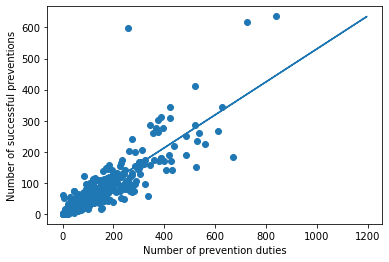

In [287]:
#Plotting a graph with the actual data points and line of predicted values

plt.scatter(X_train, y_train)
plt.plot(X_test, y_pred)
plt.xlabel('Number of prevention duties')
plt.ylabel('Number of successful preventions')
plt.show()

In [288]:
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, y_pred))

0.7726689560769123
1058.962934548141


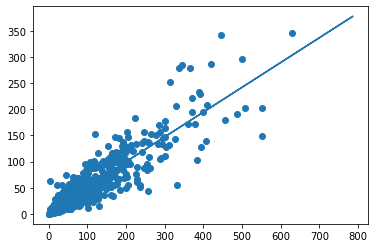

0.7221507881506806
777.2896730673589


In [289]:
#Trying the model without the Leeds outliers to see if the accuracy score changes

X = df.loc[df['local_authority'] != 'Leeds'][['total_prevention_duty']]
y = df.loc[df['local_authority'] != 'Leeds']['total_successful_prevention']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.scatter(X_train, y_train)
plt.plot(X_test, y_pred)
plt.show()

print(model.score(X_test, y_test))
print(mean_squared_error(y_test, y_pred))

In [290]:
#Trying a multiple linear regression model

from sklearn.preprocessing import StandardScaler

X = df[['total_prevention_duty', 'percentage_AST_total', 'year', 'quarter', 'population_density', 'percent_unemployed', 'deprivation_score']]
y = df['total_successful_prevention']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print(model.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred))

0.7987726560479317
937.3655924217081


In [291]:
#Showing the model coefficients, to assess which features are the most influential

model.coef_

array([ 8.03130984e+01, -2.10018580e+01,  6.14901370e+00, -3.32724057e+00,
       -3.12811573e+00,  1.89688928e+00, -3.34797695e+00, -1.65520485e-02])

In [292]:
#One hot encoding region_name column so it can be added to the regression model

one_hot = pd.get_dummies(df['region_name'])
df = df.drop('region_name',axis = 1)
df = df.join(one_hot)

In [293]:
#Trying multiple linear regression model including region name

X = df[['total_prevention_duty', 'percentage_AST_total', 'year', 'quarter', 'population_density', 'percent_unemployed', 'deprivation_score', 'East', 'East Midlands', 'London', 'North East',
       'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire and The Humber']]
y = df['total_successful_prevention']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print(model.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred))

0.7983980978619225
939.1103749598533


In [294]:
model.coef_

array([ 8.03285099e+01, -2.06945833e+01,  6.12539914e+00, -3.42470454e+00,
       -3.27549704e+00,  2.01072444e+00, -3.38333118e+00, -8.66688276e-02,
        3.31151387e-01,  8.06077931e-01, -1.78229228e-01, -3.26000272e-01,
        9.97719986e-02, -3.32106868e-02, -1.04817998e+00,  1.82503010e-01,
        1.26715923e-02])

In [295]:
#Introducing affordability data

affordability = pd.read_csv('C:/Users/lucyf/Coding/Homelessness/data/affordability.csv')

df = pd.merge(df, affordability, how='left', on=['ONS_code', 'local_authority', 'year'])

df.dropna(axis=0, inplace=True)

In [296]:
#Trying multiple linear regression model including region name & affordability data

X = df[['total_prevention_duty', 'percentage_AST_total', 'year', 'quarter', 'population_density', 'percent_unemployed', 'deprivation_score', 'affordability_ratio', 'East', 'East Midlands', 'London', 'North East',
       'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire and The Humber']]
y = df['total_successful_prevention']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print(model.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred))
print(model.coef_)

0.7429279892080045
1305.1253916484677
[ 5.41925479e+01 -6.55497245e+00  2.01004807e+00 -2.06721695e+00
 -1.51308151e+00  4.52920471e-02  3.73371671e+00 -6.06295420e-01
  3.82199556e+00 -2.53143686e-01  1.04737087e+00 -3.36188359e+00
 -1.42951928e+00  2.29023477e+00 -1.68641306e+00  4.73190257e-01
  2.85225540e+00  2.00532111e-01]


In [325]:
#Using recursive feature elimination (RFE) to select the more influential features

from sklearn.feature_selection import RFE
 
rfe = RFE(model, n_features_to_select=6)
rfe.fit(X_train, y_train)

#Show the selected features
selected_features = X.columns[rfe.support_]
print(selected_features)
print(rfe.ranking_)

#Show the accuracy score with the selected features
print("Accuracy score:", rfe.score(X_test, y_test))

Index(['total_prevention_duty', 'percentage_AST_total', 'population_density',
       'percent_unemployed', 'London', 'Yorkshire and The Humber'],
      dtype='object')
[ 1  1  4  5  1  1  7  9  6  1 10  3 12  8 11  1  2]
Accuracy score: 0.7592564137898806


In [326]:
#Importing data with Homelessness Prevention Grant info and dropping rows with null values

df_HPG = pd.read_csv('C:/Users/lucyf/Coding/Homelessness/data/master_df_with_HPG.csv')

df_HPG = pd.merge(df_HPG, affordability, how='left', on=['ONS_code', 'local_authority', 'year'])

df_HPG.dropna(axis=0, inplace=True)

#One hot encoding region names again

one_hot = pd.get_dummies(df_HPG['region_name'])
df_HPG = df_HPG.drop('region_name',axis = 1)
df_HPG = df_HPG.join(one_hot)

In [327]:
#Adding HPG data to model

X = df_HPG.dropna()[['total_prevention_duty', 'percentage_AST_total', 'year', 'quarter', 'population_density', 'percent_unemployed', 'deprivation_score', 'East', 'East Midlands', 'London', 'North East',
       'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire and The Humber', 'HPG_grant']]
y = df_HPG.dropna()['total_successful_prevention']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(model.score(X_test, y_test))
print(mean_squared_error(y_test, y_pred))
print(model.coef_)

0.7532473453839567
962.0889310075954
[58.09780199 -1.44145331 -1.92385025 -1.24449845  2.40381989 -6.47338493
 -0.76400411 -0.276101    0.79951752 -4.65741525  0.29606324  2.29736796
 -0.05945056 -0.60315824  0.14751477  2.71865952  3.12701078]


In [333]:
#Using recursive feature elimination (RFE) to select the more influential features
#Experimented with the number of features selected, to get the highest accuracy score

from sklearn.feature_selection import RFE
 
# Initialize RFE with the linear regression model and the desired number of features to select
rfe = RFE(model, n_features_to_select=6)

# Fit RFE on the training data to select the most important features
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]
print(selected_features)

print(rfe.ranking_)
print("Accuracy score:", rfe.score(X_test, y_test))

Index(['total_prevention_duty', 'percentage_AST_total', 'population_density',
       'percent_unemployed', 'London', 'Yorkshire and The Humber'],
      dtype='object')
[ 1  1  4  5  1  1  7  9  6  1 10  3 12  8 11  1  2]
Accuracy score: 0.7592564137898806


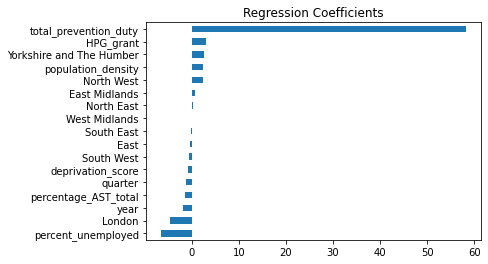

In [337]:
#Plotting a bar chart showing the coefficient of each feature

predictors = X.columns
coef = pd.Series(model.coef_, predictors).sort_values()

plt.figure()
coef.plot(kind='barh')
plt.title ("Regression Coefficients")
plt.show()

## Predicting number of prevention duties

In [348]:
#Trying a linear regression model first

X = df[['population_density', 'percent_unemployed', 'deprivation_score', 'affordability_ratio', 'East', 'East Midlands', 'London', 'North East',
       'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire and The Humber', 'year', 'quarter']]
y = df['total_prevention_duty']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("R-squared, train:", model.score(X_train_scaled, y_train))
print("R-squared, test:", model.score(X_test_scaled, y_test))
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print(model.coef_)

R-squared, train: 0.2961523333722125
R-squared, test: 0.2614243504734244
Mean squared error: 9004.956377346976
[16.02170206 29.32050385 12.32668218 -1.54676931 -2.17764125 -5.86977188
  3.77352393 -7.79788881 -0.6989594   1.02082347  7.13114178 -7.24636732
 10.58476463  7.35746962  4.22757108]


In [352]:
#Trying a decision tree algorithm to predict number of prevention duties owed

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

X = df[['year', 'quarter', 'population_density', 'percent_unemployed', 'deprivation_score', 'affordability_ratio', 'East', 'East Midlands', 'London', 'North East',
       'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire and The Humber']]
y = df['total_prevention_duty']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("R-squared, train:", model.score(X_train, y_train))
print("R-squared, test:", model.score(X_test, y_test))

R-squared, train: 1.0
R-squared, test: 0.5268394702208135
Mean squared error: 5768.928251121076


In [343]:
#Using grid search to find the best hyperparameters for decision tree

from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['squared_error', 'absolute_error', 'poisson', 'friedman_mse']
}

grid_search = GridSearchCV(model, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model on the test set using the best hyperparameters
best_dt_model = grid_search.best_estimator_
test_r2_score = best_dt_model.score(X_test, y_test)
print("Test R-squared Score:", test_r2_score)
train_r2_score = best_dt_model.score(X_train, y_train)
print("Train R-squared Score:", train_r2_score)

Best Hyperparameters: {'criterion': 'poisson', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 15}
Test R-squared Score: 0.3308441885419252
Train R-squared Score: 0.5571637545620463


In [ ]:
#Trying a RandomForest ensemble model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rf = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)

# Train the Random Forest model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared, test data:", r2)
print("R-squared, train data:", r2_score(y_train, y_pred_train))

In [358]:
#Using XG Boost Regressor model

from xgboost import XGBRegressor

X = df[['year', 'quarter', 'population_density', 'percent_unemployed', 'deprivation_score', 'affordability_ratio', 'East', 'East Midlands', 'London', 'North East',
       'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire and The Humber']]
y = df['total_prevention_duty']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=30, max_depth=9)

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

y_pred_train = model.predict(X_train)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared, test data:", r2)
print("R-squared, train data:", r2_score(y_train, y_pred_train))

Mean Absolute Error: 35.16904126932025
Mean Squared Error: 3394.228768879044
Root Mean Squared Error: 58.26001003157349
R-squared, test data: 0.7216094545529375
R-squared, train data: 0.9991901294715508


In [365]:
# Regularization using Lasso

from sklearn.linear_model import Lasso

X = df[['year', 'quarter', 'population_density', 'percent_unemployed', 'deprivation_score', 'affordability_ratio', 'East', 'East Midlands', 'London', 'North East',
       'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire and The Humber']]
y = df['total_prevention_duty']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso = Lasso(alpha = 0.8)
 
lasso.fit(X_train, y_train)
pred_train = lasso.predict(X_train)
pred_test = lasso.predict(X_test)
 
training_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)
print('Training Error:',  training_mse)
print('Test Error:', test_mse)

Training Error: 8804.34264461693
Test Error: 6452.613329956933
